In [1]:
import numpy as np
from scipy.sparse import diags

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def bermuda(F, S, K, T, v, R, d):
    mu = (R-d-0.5*v*v)
    # range x in [-x_max, x_max]
    x_max = v*np.sqrt(T)*5  # 5 stdev away            
    N = 500 
    dx = 2*x_max/N

    # grid along x dimension:
    X = np.linspace(-x_max,x_max,N+1)
    n = np.arange(0,N+1)
    # option payoff 
    if F == 'c':
        # Option payoff at maturity
        V = np.clip(S*np.exp(X)-K,0,1e10)
    elif F == 'p':
        # Option payoff at maturity
        V = np.clip(K-S*np.exp(X),0,1e10)
    cut = int(N/4)

    #number of time steps
    J = 480  # exercise every month, each month is divided into 40 steps
    # time step size
    dt = T/J
    # grid along time dimension:
    Tau = np.arange(J)*dt
    # set up the matrix
    alpha = dt*v*v/(4*dx*dx)
    beta = dt*mu/(4*dx)
    lamda = dt*R/2
    D = (1+lamda+2*alpha)*np.eye(N+1) - (alpha+beta)*np.eye(N+1,k=1) + (beta - alpha)*np.eye(N+1,k=-1)
    Dinv = np.linalg.inv(D)
    P = (1-lamda-2*alpha)*np.eye(N+1)+(alpha+beta)*np.eye(N+1,k=1)+(alpha-beta)*np.eye(N+1,k=-1)

    V0 = V.copy()
    for j in range(J): # every 40 steps, the grid coincide with an exercisable month
        if j==J-1: # the month before expiration
            Vtemp = V
        temp = P.dot(V)
        V = Dinv.dot(temp)
        # apply early/monthly exercise condition: 
        if J%40 == 0:
            V = np.where(V>V0, V, V0)
        #V[0] = 0
        # appy boundary condition at expiration
        V[N] = S*x_max*np.exp(-d*1) - K*np.exp(-R*1) # maturity at expiration is 1 year
        if j%50==0: plt.plot(S*np.exp(X[cut:-cut]), V[cut:-cut])

    #mid grid point:
    n_mid = int(N/2)
    price = V[n_mid]
    delta = (V[n_mid+1]-V[n_mid-1])/(S*np.exp(dx)-S*np.exp(-dx))
    gamma = ((V[n_mid+1]-V[n_mid])/(S*(np.exp(dx)-1))-(V[n_mid]-V[n_mid-1])/(S*(1-np.exp(-dx))))/(S*np.exp(dx)-S*np.exp(-dx))*2
    theta = -(V[n_mid]-Vtemp[n_mid])/(dt)

    return price,delta,gamma,theta

(15.907957568719132,
 0.5776879187306582,
 0.009628924147424885,
 -7.743170029509372)

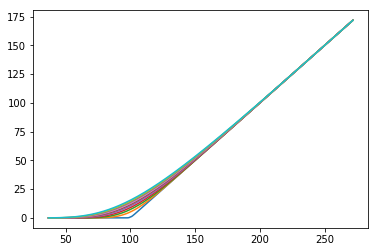

In [3]:
bermuda('c', 100, 100, 1, 0.4, 0.025, 0.0175)

In [112]:
def barrier(F, S, K, T, v, R, d, Type, H_up, H_down):
    mu = (R-d-0.5*v*v)
    # range x in [-x_max, x_max]
    x_max = v*np.sqrt(T)*5  # 5 stdev away               
    N = 500 
    dx = 2*x_max/N

    # grid along x dimension:
    X = np.linspace(-x_max,x_max,N+1)
    n = np.arange(0,N+1)
    # option payoff 
    V = np.empty(1)


    cut = int(N/4)

    #number of time steps
    J = 500  
    # time step size
    dt = T/J
    # grid along time dimension:
    Tau = np.arange(J)*dt  

    # set up the matrix
    alpha = dt*v*v/(4*dx*dx)
    beta = dt*mu/(4*dx)
    lamda = dt*R/2
    D = (1+lamda+2*alpha)*np.eye(N+1) - (alpha+beta)*np.eye(N+1,k=1) + (beta - alpha)*np.eye(N+1,k=-1)
    Dinv = np.linalg.inv(D)
    P = (1-lamda-2*alpha)*np.eye(N+1)+(alpha+beta)*np.eye(N+1,k=1)+(alpha-beta)*np.eye(N+1,k=-1)
    
    if Type == 'Single':
        # Option payoff at maturity
        if F == 'c':
            V = np.where(np.logical_and(S*np.exp(X)>K,S*np.exp(X)<H_up),S*np.exp(X)-K,0)
        elif F == 'p':
            V = np.where(np.logical_and(S*np.exp(X)<K,S*np.exp(X)<H_up),K-S*np.exp(X),0)
        
        for j in range(J):
            if j==J-1:
                Vtemp = V
            temp = P.dot(V)
            V = Dinv.dot(temp)
            V[0] = 0
#             h_idx = int(N/2)+(H_up-S)+1
#             V[h_idx:]=0
            V[N] = S*np.exp(x_max-d*j*dt) - K*np.exp(-R*j*dt)
            V = np.where(S*np.exp(X)<H_up,V,0)
            if j%50==0: plt.plot(S*np.exp(X[cut:-cut]), V[cut:-cut])
   
    elif Type == 'Double':
         # Option payoff at maturity
        if F == 'c':
            V = np.where(np.logical_and(S*np.exp(X)<K,np.logical_and(S*np.exp(X)<H_up,S*np.exp(X)>H_down)),S*np.exp(X)-K,0)
        elif F == 'p':
            V = np.where(np.logical_and(S*np.exp(X)<K,np.logical_and(S*np.exp(X)<H_up,S*np.exp(X)>H_down)),K-S*np.exp(X),0)
        for j in range(J):
            if j==J-1:
                Vtemp = V
            temp = P.dot(V)
            V = Dinv.dot(temp)
            V[0] = 0
#             h_idx = int(N/2)+(H_up-S)+1
#             V[h_idx:]=0
#             h_idx = int(N/2)-(S-H_down)+1
#             V[:h_idx]=0
            V = np.where(np.logical_and(S*np.exp(X)<H_up,S*np.exp(X)>H_down),V,0)
            plt.subplot(211)
            if j%50==0: 
                plt.plot(S*np.exp(X[cut:-cut]), V[cut:-cut])
        cut=int(N/4)
        V_temp = V[cut:-cut]
        X_temp = X[cut:-cut]
        gamma_2 = (V_temp[2:]-2*V_temp[1:-1]+V_temp[:-2])/(dx*dx*S*np.exp(X_temp[1:-1])*S*np.exp(X_temp[1:-1]))-(V_temp[2:]-V_temp[:-2])/2/(dx*S*np.exp(X_temp[1:-1])*S*np.exp(X_temp[1:-1]))
        plt.subplot(212)
        plt.plot(S*np.exp(X_temp[1:-1]),gamma_2)
        
    
    #mid grid point:
    n_mid = int(N/2)
    price = V[n_mid]
    delta = (V[n_mid+1]-V[n_mid-1])/(S*np.exp(dx)-S*np.exp(-dx))       
    gamma = ((V[n_mid+1]-V[n_mid])/(S*(np.exp(dx)-1))-(V[n_mid]-V[n_mid-1])/(S*(1-np.exp(-dx))))/(S*np.exp(dx)-S*np.exp(-dx))*2
    theta = -(V[n_mid]-Vtemp[n_mid])/(dt)


    return price,delta,gamma,theta

(0.019700612775934125,
 -0.0007513354339898518,
 -2.2307712924963064e-05,
 0.029009835692985278)

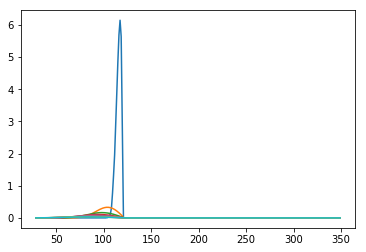

In [113]:
barrier('c', 100, 110, 1, 0.5, 0.025, 0.0175,'Single', 120, 120)

(9.84385805651797,
 -0.471437961103253,
 0.002827657126227743,
 -2.9393563148589763)

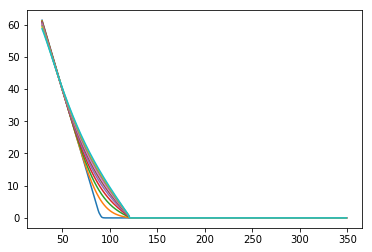

In [114]:
barrier('p', 100, 90, 1, 0.5, 0.025, 0.0175, 'Single', 120, 120)

/Users/lloydzhang/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(0.0015305921693250703,
 -8.931118655838e-06,
 -8.028632310866352e-06,
 0.010147671269369581)

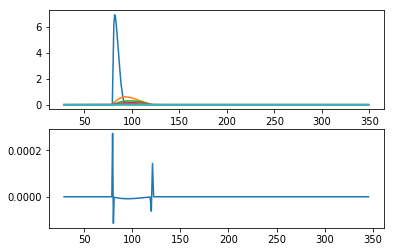

In [115]:
barrier('p', 100, 90, 1, 0.5, 0.025, 0.0175, 'Double', 120, 80)